In [7]:
from __future__ import division
import random
import pprint
import sys
import time
import numpy as np
from optparse import OptionParser
import pickle
import os

import tensorflow as tf
from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Input
from keras.models import Model
from keras_frcnn import config, data_generators
from keras_frcnn import losses as losses
import keras_frcnn.roi_helpers as roi_helpers
from keras.utils import generic_utils
from keras.callbacks import TensorBoard
from keras_frcnn import vgg as nn
from keras_frcnn.pascal_voc_parser import get_data

In [8]:
def write_log(callback, names, logs, batch_no):
    for name, value in zip(names, logs):
        summary = tf.Summary()
        summary_value = summary.value.add()
        summary_value.simple_value = value
        summary_value.tag = name
        callback.writer.add_summary(summary, batch_no)
        callback.writer.flush()

In [9]:
sys.setrecursionlimit(40000) #재귀함수 한도 증가

In [10]:
train_path = "./dataset/VOCdevkit"
config_output_filename ="./config_file/config.pickle"

num_epochs=10
#num_epochs=100

C = config.Config()
C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False
C.model_path = './config_file/model_frcnn.hdf5'
C.num_rois = 32
C.network = 'vgg'
C.base_net_weights = "./config_file/"+nn.get_weight_path()

## 데이터셋 다운로드

VOC 2012 : http://host.robots.ox.ac.uk/pascal/VOC/voc2012/

총 20가지 class. Classification, Object detection, Segementaion을 성능 측정을 위한 정보 제공

- 사람 : 사람

- 동물 : 새, 고양이, 소, 개, 말, 양

- 탈것 : 비행기, 자전거, 보트, 버스, 승용차, 오토바이, 기차

- 사물 : 병, 의자, 식탁, 화초, 소파, 모니터

In [11]:
if not os.path.exists(train_path):
#     !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar -P ./dataset
    !tar -xvf ./dataset/VOCtrainval_11-May-2012.tar -C ./dataset

In [13]:
# xml 파일 parsing
all_imgs, classes_count, class_mapping = get_data(train_path)

# background 클래스 추가
if 'bg' not in classes_count:
    classes_count['bg'] = 0
    class_mapping['bg'] = len(class_mapping)

C.class_mapping = class_mapping

inv_map = {v: k for k, v in class_mapping.items()}
print('Training images per class:')
pprint.pprint(classes_count)
print('Num classes (including bg) = {}'.format(len(classes_count)))

Parsing annotation files
Training images per class:
{'aeroplane': 954,
 'bg': 0,
 'bicycle': 790,
 'bird': 1221,
 'boat': 999,
 'bottle': 1482,
 'bus': 637,
 'car': 2364,
 'cat': 1227,
 'chair': 2906,
 'cow': 702,
 'diningtable': 747,
 'dog': 1541,
 'horse': 750,
 'motorbike': 751,
 'person': 10129,
 'pottedplant': 1099,
 'sheep': 994,
 'sofa': 786,
 'train': 656,
 'tvmonitor': 826}
Num classes (including bg) = 21


### 설정값 저장

In [14]:
with open(config_output_filename, 'wb') as config_f:
    pickle.dump(C, config_f)
    print('Config has been written to {}, and can be loaded when testing to ensure correct results'.format(config_output_filename))

Config has been written to ./config_file/config.pickle, and can be loaded when testing to ensure correct results


### 데이터 분류

In [15]:
random.shuffle(all_imgs)
num_imgs = len(all_imgs)

train_imgs = [s for s in all_imgs if s['imageset'] == 'train']
val_imgs = [s for s in all_imgs if s['imageset'] == 'val']
test_imgs = [s for s in all_imgs if s['imageset'] == 'test']

print('Num train samples {}'.format(len(train_imgs)))
print('Num val samples {}'.format(len(val_imgs)))
print('Num test samples {}'.format(len(test_imgs)))

Num train samples 5717
Num val samples 5823
Num test samples 0


In [16]:
# groundtruth anchor 데이터 가져오기
data_gen_train = data_generators.get_anchor_gt(train_imgs, classes_count, C, nn.get_img_output_length, K.image_dim_ordering(), mode='train')
data_gen_val = data_generators.get_anchor_gt(val_imgs, classes_count, C, nn.get_img_output_length, K.image_dim_ordering(), mode='val')
data_gen_test = data_generators.get_anchor_gt(test_imgs, classes_count, C, nn.get_img_output_length, K.image_dim_ordering(), mode='val')

input_shape_img = (None, None, 3)

# input placeholder 정의
img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(None, 4))

In [17]:
# base network(feature extractor) 정의
from keras_frcnn import vgg as nn_base
shared_layers = nn.nn_base(img_input, trainable=True)

In [18]:
# define the RPN, built on the base layers
# RPN 정의
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn = nn.rpn(shared_layers, num_anchors)

# detection network 정의
classifier = nn.classifier(shared_layers, roi_input, C.num_rois, nb_classes=len(classes_count), trainable=True)

model_rpn = Model(img_input, rpn[:2])
model_classifier = Model([img_input, roi_input], classifier)

# this is a model that holds both the RPN and the classifier, used to load/save weights for the models
model_all = Model([img_input, roi_input], rpn[:2] + classifier)

if not os.path.exists(C.base_net_weights):
    !wget https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5  -P ./config_file

print('loading weights from {}'.format(C.base_net_weights))
model_rpn.load_weights(C.base_net_weights, by_name=True)
model_classifier.load_weights(C.base_net_weights, by_name=True)

loading weights from ./config_file/vgg16_weights_tf_dim_ordering_tf_kernels.h5


In [19]:
optimizer = Adam(lr=1e-5)
optimizer_classifier = Adam(lr=1e-5)
model_rpn.compile(optimizer=optimizer, loss=[losses.rpn_loss_cls(num_anchors), losses.rpn_loss_regr(num_anchors)])
model_classifier.compile(optimizer=optimizer_classifier, loss=[losses.class_loss_cls, losses.class_loss_regr(len(classes_count)-1)], metrics={'dense_class_{}'.format(len(classes_count)): 'accuracy'})
model_all.compile(optimizer='sgd', loss='mae')

In [20]:
model_all.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, None, None, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, None, None, 6 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

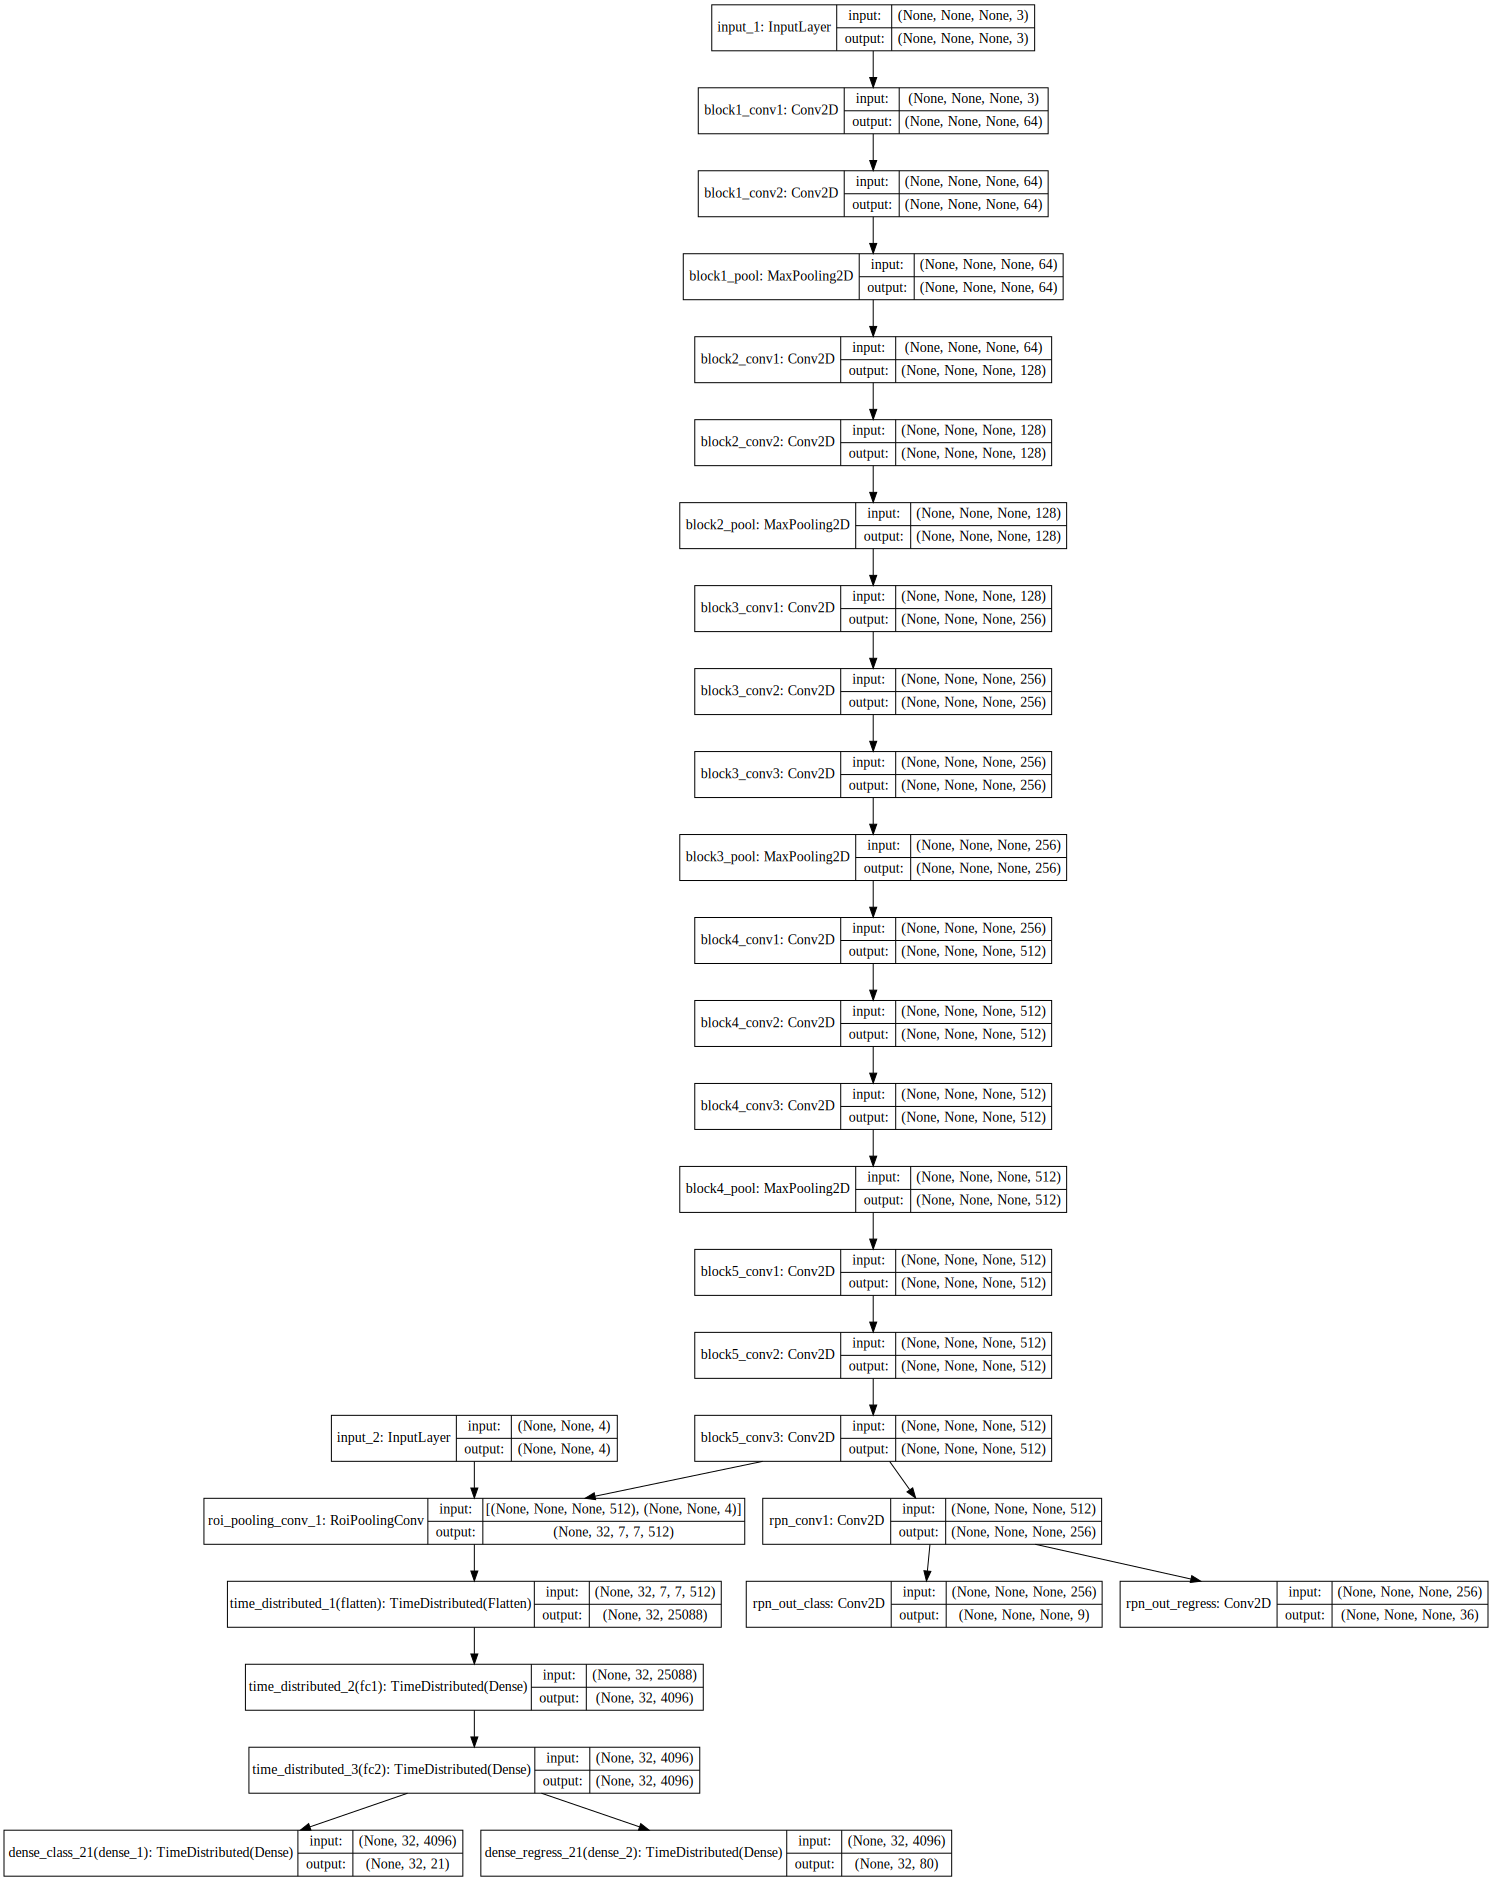

In [21]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model_all, show_shapes=True).create(prog='dot', format='svg'))

In [22]:
# Tensorboard log폴더 생성
log_path = './logs'
if not os.path.isdir(log_path):
    os.mkdir(log_path)

# Tensorboard log모델 연결
callback = TensorBoard(log_path)
callback.set_model(model_all)

epoch_length = 1000
num_epochs = int(num_epochs)
iter_num = 0
train_step = 0

losses = np.zeros((epoch_length, 5))
rpn_accuracy_rpn_monitor = []
rpn_accuracy_for_epoch = []
start_time = time.time()

best_loss = np.Inf

class_mapping_inv = {v: k for k, v in class_mapping.items()}

In [ ]:
for epoch_num in range(num_epochs):

    progbar = generic_utils.Progbar(epoch_length)   # keras progress bar 사용
    print('Epoch {}/{}'.format(epoch_num + 1, num_epochs))

    while True:
        # try:
        # mean overlapping bboxes 출력
        if len(rpn_accuracy_rpn_monitor) == epoch_length and C.verbose:
            mean_overlapping_bboxes = float(sum(rpn_accuracy_rpn_monitor))/len(rpn_accuracy_rpn_monitor)
            rpn_accuracy_rpn_monitor = []
            print('Average number of overlapping bounding boxes from RPN = {} for {} previous iterations'.format(mean_overlapping_bboxes, epoch_length))
            if mean_overlapping_bboxes == 0:
                print('RPN is not producing bounding boxes that overlap the ground truth boxes. Check RPN settings or keep training.')

        # data generator에서 X, Y, image 가져오기
        X, Y, img_data = next(data_gen_train)

        loss_rpn = model_rpn.train_on_batch(X, Y)
        write_log(callback, ['rpn_cls_loss', 'rpn_reg_loss'], loss_rpn, train_step)

        P_rpn = model_rpn.predict_on_batch(X)

        R = roi_helpers.rpn_to_roi(P_rpn[0], P_rpn[1], C, K.image_dim_ordering(), use_regr=True, overlap_thresh=0.7, max_boxes=300)
        # note: calc_iou converts from (x1,y1,x2,y2) to (x,y,w,h) format
        X2, Y1, Y2, IouS = roi_helpers.calc_iou(R, img_data, C, class_mapping)

        if X2 is None:
            rpn_accuracy_rpn_monitor.append(0)
            rpn_accuracy_for_epoch.append(0)
            continue

        # sampling positive/negative samples
        neg_samples = np.where(Y1[0, :, -1] == 1)
        pos_samples = np.where(Y1[0, :, -1] == 0)

        if len(neg_samples) > 0:
            neg_samples = neg_samples[0]
        else:
            neg_samples = []

        if len(pos_samples) > 0:
            pos_samples = pos_samples[0]
        else:
            pos_samples = []

        rpn_accuracy_rpn_monitor.append(len(pos_samples))
        rpn_accuracy_for_epoch.append((len(pos_samples)))

        if C.num_rois > 1:
            if len(pos_samples) < C.num_rois//2:
                selected_pos_samples = pos_samples.tolist()
            else:
                selected_pos_samples = np.random.choice(pos_samples, C.num_rois//2, replace=False).tolist()
            try:
                selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=False).tolist()
            except:
                selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=True).tolist()

            sel_samples = selected_pos_samples + selected_neg_samples
        else:
            # in the extreme case where num_rois = 1, we pick a random pos or neg sample
            selected_pos_samples = pos_samples.tolist()
            selected_neg_samples = neg_samples.tolist()
            if np.random.randint(0, 2):
                sel_samples = random.choice(neg_samples)
            else:
                sel_samples = random.choice(pos_samples)

        loss_class = model_classifier.train_on_batch([X, X2[:, sel_samples, :]], [Y1[:, sel_samples, :], Y2[:, sel_samples, :]])
        write_log(callback, ['detection_cls_loss', 'detection_reg_loss', 'detection_acc'], loss_class, train_step)
        train_step += 1

        losses[iter_num, 0] = loss_rpn[1]
        losses[iter_num, 1] = loss_rpn[2]

        losses[iter_num, 2] = loss_class[1]
        losses[iter_num, 3] = loss_class[2]
        losses[iter_num, 4] = loss_class[3]

        iter_num += 1

        progbar.update(iter_num, [('rpn_cls', np.mean(losses[:iter_num, 0])), ('rpn_regr', np.mean(losses[:iter_num, 1])),
                                  ('detector_cls', np.mean(losses[:iter_num, 2])), ('detector_regr', np.mean(losses[:iter_num, 3]))])

        if iter_num == epoch_length:
            loss_rpn_cls = np.mean(losses[:, 0])
            loss_rpn_regr = np.mean(losses[:, 1])
            loss_class_cls = np.mean(losses[:, 2])
            loss_class_regr = np.mean(losses[:, 3])
            class_acc = np.mean(losses[:, 4])

            mean_overlapping_bboxes = float(sum(rpn_accuracy_for_epoch)) / len(rpn_accuracy_for_epoch)
            rpn_accuracy_for_epoch = []

            if C.verbose:
                print('Mean number of bounding boxes from RPN overlapping ground truth boxes: {}'.format(mean_overlapping_bboxes))
                print('Classifier accuracy for bounding boxes from RPN: {}'.format(class_acc))
                print('Loss RPN classifier: {}'.format(loss_rpn_cls))
                print('Loss RPN regression: {}'.format(loss_rpn_regr))
                print('Loss Detector classifier: {}'.format(loss_class_cls))
                print('Loss Detector regression: {}'.format(loss_class_regr))
                print('Elapsed time: {}'.format(time.time() - start_time))

            curr_loss = loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr
            iter_num = 0
            start_time = time.time()

            write_log(callback,
                      ['Elapsed_time', 'mean_overlapping_bboxes', 'mean_rpn_cls_loss', 'mean_rpn_reg_loss',
                       'mean_detection_cls_loss', 'mean_detection_reg_loss', 'mean_detection_acc', 'total_loss'],
                      [time.time() - start_time, mean_overlapping_bboxes, loss_rpn_cls, loss_rpn_regr,
                       loss_class_cls, loss_class_regr, class_acc, curr_loss],
                      epoch_num)

            if curr_loss < best_loss:
                if C.verbose:
                    print('Total loss decreased from {} to {}, saving weights'.format(best_loss,curr_loss))
                best_loss = curr_loss
                model_all.save_weights(C.model_path)

            break

        # except Exception as e:
        #     print('Exception: {}'.format(e))
        #     continue

print('Training complete, exiting.')

Epoch 1/10
1000/1000 [==============================] - 989s 989ms/step - rpn_cls: 4.1283 - rpn_regr: 0.2314 - detector_cls: 1.4308 - detector_regr: 0.4503
Mean number of bounding boxes from RPN overlapping ground truth boxes: 13.084830339321357
Classifier accuracy for bounding boxes from RPN: 0.6813125
Loss RPN classifier: 3.1612532790968007
Loss RPN regression: 0.2150884241713211
Loss Detector classifier: 1.28123433394311
Loss Detector regression: 0.42598429848253727
Elapsed time: 989.4841377735138
Total loss decreased from inf to 5.083560335693769, saving weights
Epoch 2/10
 973/1000 [============================>.] - ETA: 21s - rpn_cls: 2.5674 - rpn_regr: 0.1943 - detector_cls: 1.0258 - detector_regr: 0.3855